In [1]:
# tryout script to do the whole pipeline on the prf data of one sub
# after try to generalize for all tasks 
# put in Nipype format (do mapNodes because then I can iterate throught files, nicer)

In [2]:
# import packages
from nilearn import image, plotting
import matplotlib.pyplot as plt
%matplotlib inline
import os
import glob
import numpy as np
import nibabel as nib
from spynoza.filtering.nodes import Savgol_filter#, Savgol_filter_confounds
from spynoza.conversion.nodes import Percent_signal_change
from nipype import Node, Function
import nipype.pipeline as pe
import nipype.interfaces.io as nio
from bids.grabbids import BIDSLayout

#from nipype.interfaces import fsl
#from nipype.interfaces import freesurfer
#from nipype.interfaces.utility import Function, IdentityInterface


In [3]:
# save relevant params used in json file, 
# afterwards just need to call the field of the list/dict
import json
analysis_params = {}
json_info = open('SBref_analysis_params.json','r').read()
analysis_params.update(json.loads(json_info))

In [4]:
#analysis_params

In [5]:
# define functions
def SGfilt_confound(confounds, tr, polyorder=3, deriv=0, window_length=120):
    import pandas as pd
    from scipy.signal import savgol_filter
    import numpy as np
    import os

    #confounds_table = pd.read_table(confounds)
    #confounds_table.fillna(method='bfill', inplace=True)
    #confounds_table = confounds_table.replace('n/a','NaN') #added this line to original spynoza func because it was giving error when str transformed to float
    confounds_table = pd.read_csv(confounds, sep='\t', na_values='n/a') #added this line to original spynoza func because it was giving error when str transformed to float
    
    window = np.int(window_length / tr)

    # Window must be odd
    if window % 2 == 0:
        window += 1

    confounds_filt = savgol_filter(confounds_table, window_length=window, polyorder=polyorder,
                              deriv=deriv, axis=0, mode='nearest')

    new_name = os.path.basename(confounds).split('.')[:-1][0] + '_sg.tsv'
    out_file = os.path.abspath(new_name)

    confounds_table = np.asarray(confounds_table).astype(np.float64) # needed to convert to float to support next operation
    pd.DataFrame(confounds_table - confounds_filt).to_csv(out_file, sep='\t', index=False)

    return out_file

In [6]:
# define paths and variables
sub_list = ['2']
ses_list = ['1']
task='prf'

source_pth = '/home/neuro/projects/data/derivatives/fmriprep/'
dest_pth = '/home/neuro/projects/data/derivatives/post_fmriprep/'
sub_num = str(sub_list[0]).zfill(2)
ses_num = str(ses_list[0]).zfill(2)

In [7]:
#gets preprocessed niftis from derivative folder
layout = BIDSLayout(source_pth)
funcdata = layout.get(subject=sub_num,task=task,extensions='space-T1w_preproc.nii.gz',return_type='file') # list of paths to functionals for this sub
confdata = layout.get(subject=sub_num,task=task,extensions='.tsv',return_type='file')  # list of paths to confounds for this sub

In [8]:
funcdata

['/home/neuro/projects/data/derivatives/fmriprep/sub-02/ses-01/func/sub-02_ses-01_task-prf_run-01_bold_space-T1w_preproc.nii.gz',
 '/home/neuro/projects/data/derivatives/fmriprep/sub-02/ses-01/func/sub-02_ses-01_task-prf_run-02_bold_space-T1w_preproc.nii.gz',
 '/home/neuro/projects/data/derivatives/fmriprep/sub-02/ses-01/func/sub-02_ses-01_task-prf_run-03_bold_space-T1w_preproc.nii.gz',
 '/home/neuro/projects/data/derivatives/fmriprep/sub-02/ses-01/func/sub-02_ses-01_task-prf_run-04_bold_space-T1w_preproc.nii.gz',
 '/home/neuro/projects/data/derivatives/fmriprep/sub-02/ses-01/func/sub-02_ses-01_task-prf_run-05_bold_space-T1w_preproc.nii.gz']

In [9]:
# do some HP filtering (Savitzky–Golay) on bold + confounds
# define Nodes
SG_filter = pe.MapNode(interface=Savgol_filter,
                       name='savgol_filt',
                       iterfield=['in_file'])
SG_filter_confounds = pe.MapNode(Function(function=SGfilt_confound),
                       name='sgfilt_confound',
                       iterfield=['confounds']) #iterfied needs different name because of temp dir

In [10]:
# define settings, right ones? 
SG_filter.inputs.polyorder = SG_filter_confounds.inputs.polyorder = analysis_params['sgfilter_polyorder']
SG_filter.inputs.deriv = SG_filter_confounds.inputs.deriv = analysis_params['sgfilter_deriv']
SG_filter.inputs.window_length = SG_filter_confounds.inputs.window_length = analysis_params['sgfilter_window_length']

if (sub_num=='01' or sub_num=='03') and ses_num=='01': # exception for some initial subjects' sessions
    SG_filter.inputs.tr = SG_filter_confounds.inputs.tr = 1.5
else:
    SG_filter.inputs.tr = SG_filter_confounds.inputs.tr = analysis_params['TR'] 

SG_filter.inputs.in_file = funcdata
SG_filter_confounds.inputs.confounds = confdata


In [11]:
# run and print outputs
res_SG_filter = SG_filter.run()
#res_SG_filter.outputs.out_file

190117-12:20:43,751 nipype.workflow INFO:
	 [Node] Setting-up "savgol_filt" in "/tmp/tmp77pv0_le/savgol_filt".
190117-12:20:43,766 nipype.workflow INFO:
	 [Node] Setting-up "_savgol_filt0" in "/tmp/tmp77pv0_le/savgol_filt/mapflow/_savgol_filt0".
190117-12:20:43,774 nipype.workflow INFO:
	 [Node] Running "_savgol_filt0" ("nipype.interfaces.utility.wrappers.Function")
190117-12:20:57,744 nipype.workflow INFO:
	 [Node] Finished "_savgol_filt0".
190117-12:20:57,753 nipype.workflow INFO:
	 [Node] Setting-up "_savgol_filt1" in "/tmp/tmp77pv0_le/savgol_filt/mapflow/_savgol_filt1".
190117-12:20:57,758 nipype.workflow INFO:
	 [Node] Running "_savgol_filt1" ("nipype.interfaces.utility.wrappers.Function")
190117-12:21:11,87 nipype.workflow INFO:
	 [Node] Finished "_savgol_filt1".
190117-12:21:11,92 nipype.workflow INFO:
	 [Node] Setting-up "_savgol_filt2" in "/tmp/tmp77pv0_le/savgol_filt/mapflow/_savgol_filt2".
190117-12:21:11,97 nipype.workflow INFO:
	 [Node] Running "_savgol_filt2" ("nipype.int

In [12]:
res_SG_filter_confounds = SG_filter_confounds.run()
#res_SG_filter_confounds.outputs.out

190117-12:22:19,226 nipype.workflow INFO:
	 [Node] Setting-up "sgfilt_confound" in "/tmp/tmpc7fvcwcc/sgfilt_confound".
190117-12:22:19,241 nipype.workflow INFO:
	 [Node] Setting-up "_sgfilt_confound0" in "/tmp/tmpc7fvcwcc/sgfilt_confound/mapflow/_sgfilt_confound0".
190117-12:22:19,249 nipype.workflow INFO:
	 [Node] Running "_sgfilt_confound0" ("nipype.interfaces.utility.wrappers.Function")
190117-12:22:19,304 nipype.workflow INFO:
	 [Node] Finished "_sgfilt_confound0".
190117-12:22:19,309 nipype.workflow INFO:
	 [Node] Setting-up "_sgfilt_confound1" in "/tmp/tmpc7fvcwcc/sgfilt_confound/mapflow/_sgfilt_confound1".
190117-12:22:19,317 nipype.workflow INFO:
	 [Node] Running "_sgfilt_confound1" ("nipype.interfaces.utility.wrappers.Function")
190117-12:22:19,348 nipype.workflow INFO:
	 [Node] Finished "_sgfilt_confound1".
190117-12:22:19,353 nipype.workflow INFO:
	 [Node] Setting-up "_sgfilt_confound2" in "/tmp/tmpc7fvcwcc/sgfilt_confound/mapflow/_sgfilt_confound2".
190117-12:22:19,362 nipy

In [13]:
#Convert data to percent signal change
#define Nodes
psc = pe.MapNode(interface=Percent_signal_change, 
              name='percent_signal_change',
             iterfield = ['in_file'])

In [14]:
# define settings
psc.inputs.func = 'median'
psc.inputs.in_file = res_SG_filter.outputs.out_file


In [15]:
# run and print outputs
res_psc = psc.run()
#res_psc.outputs.out_file

190117-12:22:27,707 nipype.workflow INFO:
	 [Node] Setting-up "percent_signal_change" in "/tmp/tmpyc39sd8b/percent_signal_change".
190117-12:22:27,720 nipype.workflow INFO:
	 [Node] Setting-up "_percent_signal_change0" in "/tmp/tmpyc39sd8b/percent_signal_change/mapflow/_percent_signal_change0".
190117-12:22:27,727 nipype.workflow INFO:
	 [Node] Running "_percent_signal_change0" ("nipype.interfaces.utility.wrappers.Function")


<string>:37: RuntimeWarning: invalid value encountered in true_divide


190117-12:22:38,869 nipype.workflow INFO:
	 [Node] Finished "_percent_signal_change0".
190117-12:22:38,872 nipype.workflow INFO:
	 [Node] Setting-up "_percent_signal_change1" in "/tmp/tmpyc39sd8b/percent_signal_change/mapflow/_percent_signal_change1".
190117-12:22:38,877 nipype.workflow INFO:
	 [Node] Running "_percent_signal_change1" ("nipype.interfaces.utility.wrappers.Function")


<string>:37: RuntimeWarning: invalid value encountered in true_divide


190117-12:22:49,768 nipype.workflow INFO:
	 [Node] Finished "_percent_signal_change1".
190117-12:22:49,772 nipype.workflow INFO:
	 [Node] Setting-up "_percent_signal_change2" in "/tmp/tmpyc39sd8b/percent_signal_change/mapflow/_percent_signal_change2".
190117-12:22:49,777 nipype.workflow INFO:
	 [Node] Running "_percent_signal_change2" ("nipype.interfaces.utility.wrappers.Function")


<string>:37: RuntimeWarning: invalid value encountered in true_divide


190117-12:23:00,893 nipype.workflow INFO:
	 [Node] Finished "_percent_signal_change2".
190117-12:23:00,896 nipype.workflow INFO:
	 [Node] Setting-up "_percent_signal_change3" in "/tmp/tmpyc39sd8b/percent_signal_change/mapflow/_percent_signal_change3".
190117-12:23:00,900 nipype.workflow INFO:
	 [Node] Running "_percent_signal_change3" ("nipype.interfaces.utility.wrappers.Function")


<string>:37: RuntimeWarning: invalid value encountered in true_divide


190117-12:23:12,463 nipype.workflow INFO:
	 [Node] Finished "_percent_signal_change3".
190117-12:23:12,468 nipype.workflow INFO:
	 [Node] Setting-up "_percent_signal_change4" in "/tmp/tmpyc39sd8b/percent_signal_change/mapflow/_percent_signal_change4".
190117-12:23:12,471 nipype.workflow INFO:
	 [Node] Running "_percent_signal_change4" ("nipype.interfaces.utility.wrappers.Function")


<string>:37: RuntimeWarning: invalid value encountered in true_divide


190117-12:23:24,24 nipype.workflow INFO:
	 [Node] Finished "_percent_signal_change4".
190117-12:23:24,29 nipype.workflow INFO:
	 [Node] Finished "percent_signal_change".


In [ ]:
nifti_file = funcdata
confounds_file = confdata
which_confounds = analysis_params['nuisance_columns']
output_pth = dest_pth+'sub-'+sub_num+'/ses-'+ses_num+'/func/'

In [26]:
def nistats_confound_pca_glm(nifti_file, confounds_file, which_confounds,output_pth):    # function adapted from utils.py in pearl_7T Git
    
    import pandas as pd
    import nibabel as nb
    import numpy as np
    from nistats.regression import OLSModel
    from scipy.stats import zscore
    from nilearn.image import math_img
    from nilearn.plotting import plot_stat_map
    import matplotlib.pyplot as plt
    from sklearn.decomposition import PCA

    infile = nb.load(nifti_file)
    mean_img = math_img('np.mean(infile, axis=-1)', infile=infile)
    in_data = infile.get_data().astype(np.float32)
    
    confounds_table = pd.read_csv(confounds_file, sep='\t', na_values='n/a')[which_confounds] #select subgroup of confounds
    
    # Z-SCORING 1ST, THEN OBTAINING COMPONENTS
    # we assume the confounds nor the nifti_file need temporal filtering 
    z_conf = confounds_table.apply(zscore) #do zscore of each value in the sample (scale data matrix)
    
    pca = PCA(0.95,whiten=True) #choose the minimum number of principal components such that at least 95% of the variance is retained.
    pca_confs = pca.fit_transform(np.nan_to_num(z_conf))
    num_comp = pca.n_components_

    all_confs = pd.DataFrame(pca_confs, columns=['comp_{n}'.format(n=n) for n in range(num_comp)])
    all_confs['intercept'] = np.ones(infile.shape[-1]) #add an intercept column filled with ones
    
    om = OLSModel(np.array(all_confs)) #create a least squares model based on nuisances
    om_rr = om.fit(in_data.reshape((-1,infile.shape[-1])).T) #fit bold data to model
    
    resid_img = nb.Nifti1Image(om_rr.resid.T.reshape(infile.shape).astype(np.float32), affine=infile.affine, header=infile.header)
    cleaned_img = math_img('(resid_img + mean_img[...,np.newaxis]).astype(np.float32)', resid_img=resid_img, mean_img=mean_img)
    
    output_nifti = output_pth+os.path.basename(nifti_file).replace('.nii.gz', '_nuis.nii.gz')
    cleaned_img.to_filename(output_nifti)
    
    output_pdf = output_pth+os.path.basename(confounds_file).replace('.tsv', '_sd-diff.pdf')
    f = plt.figure(figsize=(24,6))
    plot_stat_map(math_img('(infile.std(axis=-1)-cleaned_img.std(axis=-1))/infile.std(axis=-1)', infile=infile, cleaned_img=cleaned_img), 
                bg_img=mean_img, figure=f, cut_coords=(0,0,0), threshold=0.125, vmax=1, cmap='viridis', output_file=output_pdf)
    
    return output_pdf, output_nifti
    

In [16]:
# # def nistats_confound_glm(nifti_file, confounds_file, which_confounds):
# import pandas as pd
# import nibabel as nb
# import numpy as np
# from nistats.regression import OLSModel
# from scipy.stats import zscore
# from nilearn.image import math_img
# from nilearn.plotting import plot_stat_map
# import matplotlib.pyplot as plt

# infile = nb.load(funcdata[0])
# mean_img = math_img('np.mean(infile, axis=-1)', infile=infile)
# in_data = infile.get_data().astype(np.float32)

In [17]:
# confounds_table = pd.read_csv(confdata[0], sep='\t', na_values='n/a')[analysis_params['nuisance_columns']] #select subgroup of confounds

In [18]:
# # Z-SCORING 1ST, THEN OBTAINING COMPONENTS
# # we assume the confounds nor the nifti_file need temporal filtering 
# z_conf = confounds_table.apply(zscore) #do zscore of each value in the sample (scale data matrix)

# from sklearn.decomposition import PCA
# pca = PCA(0.95,whiten=True) #choose the minimum number of principal components such that 95% of the variance is retained.
# pca_confs = pca.fit_transform(np.nan_to_num(z_conf))
# num_comp = pca.n_components_

# #print(pca.explained_variance_)
# #print(pca.explained_variance_ratio_)
# #print(pca.explained_variance_ratio_.cumsum())

# all_confs = pd.DataFrame(pca_confs, columns=['comp_{n}'.format(n=n) for n in range(num_comp)])
# #print(all_confs)

In [166]:

# # STANDARD SCALING 1ST, THEN OBTAINING COMPONENTS
# # we assume the confounds nor the nifti_file need temporal filtering 
# from sklearn.preprocessing import StandardScaler
# stand_conf = StandardScaler().fit_transform(np.nan_to_num(confounds_table))

# from sklearn.decomposition import PCA
# pca = PCA(0.95,whiten=True) #choose the minimum number of principal components such that 95% of the variance is retained.
# pca_confs = pca.fit_transform(np.nan_to_num(stand_conf))
# num_comp = pca.n_components_

# print(pca.explained_variance_)
# print(pca.explained_variance_ratio_)
# print(pca.explained_variance_ratio_.cumsum())

# all_confs = pd.DataFrame(pca_confs, columns=['comp_{n}'.format(n=n) for n in range(num_comp)])
# print(all_confs)

In [165]:

# # NO SCALING, JUST OBTAINING COMPONENTS
# # we assume the confounds nor the nifti_file need temporal filtering 

# from sklearn.decomposition import PCA
# pca = PCA(0.95,whiten=True) #choose the minimum number of principal components such that 95% of the variance is retained.
# pca_confs = pca.fit_transform(np.nan_to_num(confounds_table))
# num_comp = pca.n_components_

# print(pca.explained_variance_)
# print(pca.explained_variance_ratio_)
# print(pca.explained_variance_ratio_.cumsum())

# all_confs = pd.DataFrame(pca_confs, columns=['comp_{n}'.format(n=n) for n in range(num_comp)])
# print(all_confs)

In [19]:
# all_confs['intercept'] = np.ones(infile.shape[-1]) #add an intercept column filled with ones

In [20]:
# om = OLSModel(np.array(all_confs)) #create a least squares model based on nuisances
# om_rr = om.fit(in_data.reshape((-1,infile.shape[-1])).T) #fit bold data to model

In [21]:
# resid_img = nb.Nifti1Image(om_rr.resid.T.reshape(infile.shape).astype(np.float32), affine=infile.affine, header=infile.header)
# cleaned_img = math_img('(resid_img + mean_img[...,np.newaxis]).astype(np.float32)', resid_img=resid_img, mean_img=mean_img)

In [22]:
# output_nifti = os.path.basename(funcdata[0]).replace('.nii.gz', '_nuis.nii.gz')
# #os.mkdir(dest_pth+'sub-'+sub_num+'/ses-'+ses_num+'/func/',mode=777); # creates folder that I cannot access or delete in aeneas
# cleaned_img.to_filename(dest_pth+'sub-'+sub_num+'/ses-'+ses_num+'/func/'+output_nifti)

In [25]:
# output_pdf = dest_pth+'sub-'+sub_num+'/ses-'+ses_num+'/func/'+os.path.basename(confdata[0]).replace('.tsv', '_sd-diff.pdf')
# f = plt.figure(figsize=(24,6))
# plot_stat_map(math_img('(infile.std(axis=-1)-cleaned_img.std(axis=-1))/infile.std(axis=-1)', infile=infile, cleaned_img=cleaned_img), 
#                 bg_img=mean_img, figure=f, cut_coords=(0,0,0), threshold=0.125, vmax=1, cmap='viridis', output_file=output_pdf)

/opt/miniconda-latest/envs/neuro/lib/python3.6/site-packages/numpy/core/_methods.py:138: RuntimeWarning: invalid value encountered in sqrt
  ret = um.sqrt(ret, out=ret)
<string>:1: RuntimeWarning: invalid value encountered in true_divide


In [405]:
# Use confounds as nuisance regressors in a GLM
#define Node
confGLM = pe.MapNode(Function(input_names=['nifti_file', 'confounds_file', 'which_confounds'], 
                              output_names=['output_pdf', 'output_nifti'],
                             function=nistats_confound_glm),
                             name='nistats_confound_glm', 
                             iterfield=["nifti_file", "confounds_file"])

In [406]:
# define settings
confGLM.inputs.which_confounds = analysis_params['nuisance_columns']
confGLM.inputs.nifti_file = res_psc.outputs.out_file
confGLM.inputs.confounds_file = res_SG_filter_confounds.outputs.out

In [407]:
# run and print outputs
confGLM.run()

181214-16:06:36,349 nipype.workflow INFO:
	 [Node] Setting-up "nistats_confound_glm" in "/tmp/tmp1whbgcmo/nistats_confound_glm".
181214-16:06:36,355 nipype.workflow INFO:
	 [Node] Setting-up "_nistats_confound_glm0" in "/tmp/tmp1whbgcmo/nistats_confound_glm/mapflow/_nistats_confound_glm0".
181214-16:06:36,359 nipype.workflow INFO:
	 [Node] Running "_nistats_confound_glm0" ("nipype.interfaces.utility.wrappers.Function")
181214-16:06:37,828 nipype.workflow WARNING:
	 [Node] Error on "_nistats_confound_glm0" (/tmp/tmp1whbgcmo/nistats_confound_glm/mapflow/_nistats_confound_glm0)
181214-16:06:37,870 nipype.workflow INFO:
	 [Node] Setting-up "_nistats_confound_glm1" in "/tmp/tmp1whbgcmo/nistats_confound_glm/mapflow/_nistats_confound_glm1".
181214-16:06:37,875 nipype.workflow INFO:
	 [Node] Running "_nistats_confound_glm1" ("nipype.interfaces.utility.wrappers.Function")
181214-16:06:39,141 nipype.workflow WARNING:
	 [Node] Error on "_nistats_confound_glm1" (/tmp/tmp1whbgcmo/nistats_confound_g

Exception: Subnodes of node: nistats_confound_glm failed:
Subnode 0 failed
Error: Traceback (most recent call last):

  File "/opt/miniconda-latest/envs/neuro/lib/python3.6/site-packages/pandas/core/indexes/base.py", line 2442, in get_loc
    return self._engine.get_loc(key)

  File "pandas/_libs/index.pyx", line 132, in pandas._libs.index.IndexEngine.get_loc (pandas/_libs/index.c:5280)

  File "pandas/_libs/index.pyx", line 154, in pandas._libs.index.IndexEngine.get_loc (pandas/_libs/index.c:5126)

  File "pandas/_libs/hashtable_class_helper.pxi", line 1210, in pandas._libs.hashtable.PyObjectHashTable.get_item (pandas/_libs/hashtable.c:20523)

  File "pandas/_libs/hashtable_class_helper.pxi", line 1218, in pandas._libs.hashtable.PyObjectHashTable.get_item (pandas/_libs/hashtable.c:20477)

KeyError: 'CSF'


During handling of the above exception, another exception occurred:


Traceback (most recent call last):

  File "/opt/miniconda-latest/envs/neuro/lib/python3.6/site-packages/nipype/pipeline/engine/utils.py", line 106, in nodelist_runner
    result = node.run(updatehash=updatehash)

  File "/opt/miniconda-latest/envs/neuro/lib/python3.6/site-packages/nipype/pipeline/engine/nodes.py", line 480, in run
    result = self._run_interface(execute=True)

  File "/opt/miniconda-latest/envs/neuro/lib/python3.6/site-packages/nipype/pipeline/engine/nodes.py", line 564, in _run_interface
    return self._run_command(execute)

  File "/opt/miniconda-latest/envs/neuro/lib/python3.6/site-packages/nipype/pipeline/engine/nodes.py", line 644, in _run_command
    result = self._interface.run(cwd=outdir)

  File "/opt/miniconda-latest/envs/neuro/lib/python3.6/site-packages/nipype/interfaces/base/core.py", line 521, in run
    runtime = self._run_interface(runtime)

  File "/opt/miniconda-latest/envs/neuro/lib/python3.6/site-packages/nipype/interfaces/utility/wrappers.py", line 144, in _run_interface
    out = function_handle(**args)

  File "<string>", line 17, in nistats_confound_glm

  File "/opt/miniconda-latest/envs/neuro/lib/python3.6/site-packages/pandas/core/frame.py", line 1964, in __getitem__
    return self._getitem_column(key)

  File "/opt/miniconda-latest/envs/neuro/lib/python3.6/site-packages/pandas/core/frame.py", line 1971, in _getitem_column
    return self._get_item_cache(key)

  File "/opt/miniconda-latest/envs/neuro/lib/python3.6/site-packages/pandas/core/generic.py", line 1645, in _get_item_cache
    values = self._data.get(item)

  File "/opt/miniconda-latest/envs/neuro/lib/python3.6/site-packages/pandas/core/internals.py", line 3590, in get
    loc = self.items.get_loc(item)

  File "/opt/miniconda-latest/envs/neuro/lib/python3.6/site-packages/pandas/core/indexes/base.py", line 2444, in get_loc
    return self._engine.get_loc(self._maybe_cast_indexer(key))

  File "pandas/_libs/index.pyx", line 132, in pandas._libs.index.IndexEngine.get_loc (pandas/_libs/index.c:5280)

  File "pandas/_libs/index.pyx", line 154, in pandas._libs.index.IndexEngine.get_loc (pandas/_libs/index.c:5126)

  File "pandas/_libs/hashtable_class_helper.pxi", line 1210, in pandas._libs.hashtable.PyObjectHashTable.get_item (pandas/_libs/hashtable.c:20523)

  File "pandas/_libs/hashtable_class_helper.pxi", line 1218, in pandas._libs.hashtable.PyObjectHashTable.get_item (pandas/_libs/hashtable.c:20477)

KeyError: 'CSF'

Subnode 1 failed
Error: Traceback (most recent call last):

  File "/opt/miniconda-latest/envs/neuro/lib/python3.6/site-packages/pandas/core/indexes/base.py", line 2442, in get_loc
    return self._engine.get_loc(key)

  File "pandas/_libs/index.pyx", line 132, in pandas._libs.index.IndexEngine.get_loc (pandas/_libs/index.c:5280)

  File "pandas/_libs/index.pyx", line 154, in pandas._libs.index.IndexEngine.get_loc (pandas/_libs/index.c:5126)

  File "pandas/_libs/hashtable_class_helper.pxi", line 1210, in pandas._libs.hashtable.PyObjectHashTable.get_item (pandas/_libs/hashtable.c:20523)

  File "pandas/_libs/hashtable_class_helper.pxi", line 1218, in pandas._libs.hashtable.PyObjectHashTable.get_item (pandas/_libs/hashtable.c:20477)

KeyError: 'CSF'


During handling of the above exception, another exception occurred:


Traceback (most recent call last):

  File "/opt/miniconda-latest/envs/neuro/lib/python3.6/site-packages/nipype/pipeline/engine/utils.py", line 106, in nodelist_runner
    result = node.run(updatehash=updatehash)

  File "/opt/miniconda-latest/envs/neuro/lib/python3.6/site-packages/nipype/pipeline/engine/nodes.py", line 480, in run
    result = self._run_interface(execute=True)

  File "/opt/miniconda-latest/envs/neuro/lib/python3.6/site-packages/nipype/pipeline/engine/nodes.py", line 564, in _run_interface
    return self._run_command(execute)

  File "/opt/miniconda-latest/envs/neuro/lib/python3.6/site-packages/nipype/pipeline/engine/nodes.py", line 644, in _run_command
    result = self._interface.run(cwd=outdir)

  File "/opt/miniconda-latest/envs/neuro/lib/python3.6/site-packages/nipype/interfaces/base/core.py", line 521, in run
    runtime = self._run_interface(runtime)

  File "/opt/miniconda-latest/envs/neuro/lib/python3.6/site-packages/nipype/interfaces/utility/wrappers.py", line 144, in _run_interface
    out = function_handle(**args)

  File "<string>", line 17, in nistats_confound_glm

  File "/opt/miniconda-latest/envs/neuro/lib/python3.6/site-packages/pandas/core/frame.py", line 1964, in __getitem__
    return self._getitem_column(key)

  File "/opt/miniconda-latest/envs/neuro/lib/python3.6/site-packages/pandas/core/frame.py", line 1971, in _getitem_column
    return self._get_item_cache(key)

  File "/opt/miniconda-latest/envs/neuro/lib/python3.6/site-packages/pandas/core/generic.py", line 1645, in _get_item_cache
    values = self._data.get(item)

  File "/opt/miniconda-latest/envs/neuro/lib/python3.6/site-packages/pandas/core/internals.py", line 3590, in get
    loc = self.items.get_loc(item)

  File "/opt/miniconda-latest/envs/neuro/lib/python3.6/site-packages/pandas/core/indexes/base.py", line 2444, in get_loc
    return self._engine.get_loc(self._maybe_cast_indexer(key))

  File "pandas/_libs/index.pyx", line 132, in pandas._libs.index.IndexEngine.get_loc (pandas/_libs/index.c:5280)

  File "pandas/_libs/index.pyx", line 154, in pandas._libs.index.IndexEngine.get_loc (pandas/_libs/index.c:5126)

  File "pandas/_libs/hashtable_class_helper.pxi", line 1210, in pandas._libs.hashtable.PyObjectHashTable.get_item (pandas/_libs/hashtable.c:20523)

  File "pandas/_libs/hashtable_class_helper.pxi", line 1218, in pandas._libs.hashtable.PyObjectHashTable.get_item (pandas/_libs/hashtable.c:20477)

KeyError: 'CSF'

Subnode 2 failed
Error: Traceback (most recent call last):

  File "/opt/miniconda-latest/envs/neuro/lib/python3.6/site-packages/pandas/core/indexes/base.py", line 2442, in get_loc
    return self._engine.get_loc(key)

  File "pandas/_libs/index.pyx", line 132, in pandas._libs.index.IndexEngine.get_loc (pandas/_libs/index.c:5280)

  File "pandas/_libs/index.pyx", line 154, in pandas._libs.index.IndexEngine.get_loc (pandas/_libs/index.c:5126)

  File "pandas/_libs/hashtable_class_helper.pxi", line 1210, in pandas._libs.hashtable.PyObjectHashTable.get_item (pandas/_libs/hashtable.c:20523)

  File "pandas/_libs/hashtable_class_helper.pxi", line 1218, in pandas._libs.hashtable.PyObjectHashTable.get_item (pandas/_libs/hashtable.c:20477)

KeyError: 'CSF'


During handling of the above exception, another exception occurred:


Traceback (most recent call last):

  File "/opt/miniconda-latest/envs/neuro/lib/python3.6/site-packages/nipype/pipeline/engine/utils.py", line 106, in nodelist_runner
    result = node.run(updatehash=updatehash)

  File "/opt/miniconda-latest/envs/neuro/lib/python3.6/site-packages/nipype/pipeline/engine/nodes.py", line 480, in run
    result = self._run_interface(execute=True)

  File "/opt/miniconda-latest/envs/neuro/lib/python3.6/site-packages/nipype/pipeline/engine/nodes.py", line 564, in _run_interface
    return self._run_command(execute)

  File "/opt/miniconda-latest/envs/neuro/lib/python3.6/site-packages/nipype/pipeline/engine/nodes.py", line 644, in _run_command
    result = self._interface.run(cwd=outdir)

  File "/opt/miniconda-latest/envs/neuro/lib/python3.6/site-packages/nipype/interfaces/base/core.py", line 521, in run
    runtime = self._run_interface(runtime)

  File "/opt/miniconda-latest/envs/neuro/lib/python3.6/site-packages/nipype/interfaces/utility/wrappers.py", line 144, in _run_interface
    out = function_handle(**args)

  File "<string>", line 17, in nistats_confound_glm

  File "/opt/miniconda-latest/envs/neuro/lib/python3.6/site-packages/pandas/core/frame.py", line 1964, in __getitem__
    return self._getitem_column(key)

  File "/opt/miniconda-latest/envs/neuro/lib/python3.6/site-packages/pandas/core/frame.py", line 1971, in _getitem_column
    return self._get_item_cache(key)

  File "/opt/miniconda-latest/envs/neuro/lib/python3.6/site-packages/pandas/core/generic.py", line 1645, in _get_item_cache
    values = self._data.get(item)

  File "/opt/miniconda-latest/envs/neuro/lib/python3.6/site-packages/pandas/core/internals.py", line 3590, in get
    loc = self.items.get_loc(item)

  File "/opt/miniconda-latest/envs/neuro/lib/python3.6/site-packages/pandas/core/indexes/base.py", line 2444, in get_loc
    return self._engine.get_loc(self._maybe_cast_indexer(key))

  File "pandas/_libs/index.pyx", line 132, in pandas._libs.index.IndexEngine.get_loc (pandas/_libs/index.c:5280)

  File "pandas/_libs/index.pyx", line 154, in pandas._libs.index.IndexEngine.get_loc (pandas/_libs/index.c:5126)

  File "pandas/_libs/hashtable_class_helper.pxi", line 1210, in pandas._libs.hashtable.PyObjectHashTable.get_item (pandas/_libs/hashtable.c:20523)

  File "pandas/_libs/hashtable_class_helper.pxi", line 1218, in pandas._libs.hashtable.PyObjectHashTable.get_item (pandas/_libs/hashtable.c:20477)

KeyError: 'CSF'

Subnode 3 failed
Error: Traceback (most recent call last):

  File "/opt/miniconda-latest/envs/neuro/lib/python3.6/site-packages/pandas/core/indexes/base.py", line 2442, in get_loc
    return self._engine.get_loc(key)

  File "pandas/_libs/index.pyx", line 132, in pandas._libs.index.IndexEngine.get_loc (pandas/_libs/index.c:5280)

  File "pandas/_libs/index.pyx", line 154, in pandas._libs.index.IndexEngine.get_loc (pandas/_libs/index.c:5126)

  File "pandas/_libs/hashtable_class_helper.pxi", line 1210, in pandas._libs.hashtable.PyObjectHashTable.get_item (pandas/_libs/hashtable.c:20523)

  File "pandas/_libs/hashtable_class_helper.pxi", line 1218, in pandas._libs.hashtable.PyObjectHashTable.get_item (pandas/_libs/hashtable.c:20477)

KeyError: 'CSF'


During handling of the above exception, another exception occurred:


Traceback (most recent call last):

  File "/opt/miniconda-latest/envs/neuro/lib/python3.6/site-packages/nipype/pipeline/engine/utils.py", line 106, in nodelist_runner
    result = node.run(updatehash=updatehash)

  File "/opt/miniconda-latest/envs/neuro/lib/python3.6/site-packages/nipype/pipeline/engine/nodes.py", line 480, in run
    result = self._run_interface(execute=True)

  File "/opt/miniconda-latest/envs/neuro/lib/python3.6/site-packages/nipype/pipeline/engine/nodes.py", line 564, in _run_interface
    return self._run_command(execute)

  File "/opt/miniconda-latest/envs/neuro/lib/python3.6/site-packages/nipype/pipeline/engine/nodes.py", line 644, in _run_command
    result = self._interface.run(cwd=outdir)

  File "/opt/miniconda-latest/envs/neuro/lib/python3.6/site-packages/nipype/interfaces/base/core.py", line 521, in run
    runtime = self._run_interface(runtime)

  File "/opt/miniconda-latest/envs/neuro/lib/python3.6/site-packages/nipype/interfaces/utility/wrappers.py", line 144, in _run_interface
    out = function_handle(**args)

  File "<string>", line 17, in nistats_confound_glm

  File "/opt/miniconda-latest/envs/neuro/lib/python3.6/site-packages/pandas/core/frame.py", line 1964, in __getitem__
    return self._getitem_column(key)

  File "/opt/miniconda-latest/envs/neuro/lib/python3.6/site-packages/pandas/core/frame.py", line 1971, in _getitem_column
    return self._get_item_cache(key)

  File "/opt/miniconda-latest/envs/neuro/lib/python3.6/site-packages/pandas/core/generic.py", line 1645, in _get_item_cache
    values = self._data.get(item)

  File "/opt/miniconda-latest/envs/neuro/lib/python3.6/site-packages/pandas/core/internals.py", line 3590, in get
    loc = self.items.get_loc(item)

  File "/opt/miniconda-latest/envs/neuro/lib/python3.6/site-packages/pandas/core/indexes/base.py", line 2444, in get_loc
    return self._engine.get_loc(self._maybe_cast_indexer(key))

  File "pandas/_libs/index.pyx", line 132, in pandas._libs.index.IndexEngine.get_loc (pandas/_libs/index.c:5280)

  File "pandas/_libs/index.pyx", line 154, in pandas._libs.index.IndexEngine.get_loc (pandas/_libs/index.c:5126)

  File "pandas/_libs/hashtable_class_helper.pxi", line 1210, in pandas._libs.hashtable.PyObjectHashTable.get_item (pandas/_libs/hashtable.c:20523)

  File "pandas/_libs/hashtable_class_helper.pxi", line 1218, in pandas._libs.hashtable.PyObjectHashTable.get_item (pandas/_libs/hashtable.c:20477)

KeyError: 'CSF'

Subnode 4 failed
Error: Traceback (most recent call last):

  File "/opt/miniconda-latest/envs/neuro/lib/python3.6/site-packages/pandas/core/indexes/base.py", line 2442, in get_loc
    return self._engine.get_loc(key)

  File "pandas/_libs/index.pyx", line 132, in pandas._libs.index.IndexEngine.get_loc (pandas/_libs/index.c:5280)

  File "pandas/_libs/index.pyx", line 154, in pandas._libs.index.IndexEngine.get_loc (pandas/_libs/index.c:5126)

  File "pandas/_libs/hashtable_class_helper.pxi", line 1210, in pandas._libs.hashtable.PyObjectHashTable.get_item (pandas/_libs/hashtable.c:20523)

  File "pandas/_libs/hashtable_class_helper.pxi", line 1218, in pandas._libs.hashtable.PyObjectHashTable.get_item (pandas/_libs/hashtable.c:20477)

KeyError: 'CSF'


During handling of the above exception, another exception occurred:


Traceback (most recent call last):

  File "/opt/miniconda-latest/envs/neuro/lib/python3.6/site-packages/nipype/pipeline/engine/utils.py", line 106, in nodelist_runner
    result = node.run(updatehash=updatehash)

  File "/opt/miniconda-latest/envs/neuro/lib/python3.6/site-packages/nipype/pipeline/engine/nodes.py", line 480, in run
    result = self._run_interface(execute=True)

  File "/opt/miniconda-latest/envs/neuro/lib/python3.6/site-packages/nipype/pipeline/engine/nodes.py", line 564, in _run_interface
    return self._run_command(execute)

  File "/opt/miniconda-latest/envs/neuro/lib/python3.6/site-packages/nipype/pipeline/engine/nodes.py", line 644, in _run_command
    result = self._interface.run(cwd=outdir)

  File "/opt/miniconda-latest/envs/neuro/lib/python3.6/site-packages/nipype/interfaces/base/core.py", line 521, in run
    runtime = self._run_interface(runtime)

  File "/opt/miniconda-latest/envs/neuro/lib/python3.6/site-packages/nipype/interfaces/utility/wrappers.py", line 144, in _run_interface
    out = function_handle(**args)

  File "<string>", line 17, in nistats_confound_glm

  File "/opt/miniconda-latest/envs/neuro/lib/python3.6/site-packages/pandas/core/frame.py", line 1964, in __getitem__
    return self._getitem_column(key)

  File "/opt/miniconda-latest/envs/neuro/lib/python3.6/site-packages/pandas/core/frame.py", line 1971, in _getitem_column
    return self._get_item_cache(key)

  File "/opt/miniconda-latest/envs/neuro/lib/python3.6/site-packages/pandas/core/generic.py", line 1645, in _get_item_cache
    values = self._data.get(item)

  File "/opt/miniconda-latest/envs/neuro/lib/python3.6/site-packages/pandas/core/internals.py", line 3590, in get
    loc = self.items.get_loc(item)

  File "/opt/miniconda-latest/envs/neuro/lib/python3.6/site-packages/pandas/core/indexes/base.py", line 2444, in get_loc
    return self._engine.get_loc(self._maybe_cast_indexer(key))

  File "pandas/_libs/index.pyx", line 132, in pandas._libs.index.IndexEngine.get_loc (pandas/_libs/index.c:5280)

  File "pandas/_libs/index.pyx", line 154, in pandas._libs.index.IndexEngine.get_loc (pandas/_libs/index.c:5126)

  File "pandas/_libs/hashtable_class_helper.pxi", line 1210, in pandas._libs.hashtable.PyObjectHashTable.get_item (pandas/_libs/hashtable.c:20523)

  File "pandas/_libs/hashtable_class_helper.pxi", line 1218, in pandas._libs.hashtable.PyObjectHashTable.get_item (pandas/_libs/hashtable.c:20477)

KeyError: 'CSF'


In [234]:
#import pandas
#pd.read_table(confdata[0])

In [286]:
from nilearn.image import math_img
(math_img('np.mean(aa,axis=-1)',aa=nib.load(funcdata[1]))).shape

(79, 105, 82)

In [287]:
nib.load(funcdata[1]).get_data().astype(np.float32).shape

(79, 105, 82, 90)

In [408]:
import pandas
cc = ["CSF", "WhiteMatter", "GlobalSignal", "stdDVARS","non-stdDVARS","vx-wisestdDVARS","FramewiseDisplacement",
                                "tCompCor00","tCompCor01","tCompCor02","tCompCor03","tCompCor04","tCompCor05","aCompCor00","aCompCor01",
                                "aCompCor02","aCompCor03","aCompCor04","aCompCor05","X","Y","Z","RotX","RotY","RotZ"]

bb = pd.read_table(confdata[0])[analysis_params['nuisance_columns'][0]]#cc[0]]
bb2 = pd.read_table(confdata[0])[analysis_params['nuisance_columns'][0]]#['WhiteMatter']
#bb.append(bb2)
bb3 = pd.concat([bb, bb2],axis=1)

In [409]:
type(bb3)

pandas.core.frame.DataFrame

In [379]:
type(cc)
cc

['CSF',
 'WhiteMatter',
 'GlobalSignal',
 'stdDVARS',
 'non-stdDVARS',
 'vx-wisestdDVARS',
 'FramewiseDisplacement',
 'tCompCor00',
 'tCompCor01',
 'tCompCor02',
 'tCompCor03',
 'tCompCor04',
 'tCompCor05',
 'aCompCor00',
 'aCompCor01',
 'aCompCor02',
 'aCompCor03',
 'aCompCor04',
 'aCompCor05',
 'X',
 'Y',
 'Z',
 'RotX',
 'RotY',
 'RotZ']

In [377]:
type(analysis_params['nuisance_columns'])

list

In [384]:
range(len(analysis_params['nuisance_columns']))

range(0, 25)

In [410]:
for i in range((len(analysis_params['nuisance_columns'])-1)): #do loop because then table is pandas.core.frame.DataFrame and avoids error because which_condfounds is list
    if i == 0:
        conf = pd.read_table(confdata[0])[analysis_params['nuisance_columns'][i]]
        conf2 = pd.read_table(confdata[0])[analysis_params['nuisance_columns'][i+1]]
        confounds_table = pd.concat([conf, conf2],axis=1)
    else:
        confounds_table = pd.concat([confounds_table, pd.read_table(confdata[0])[analysis_params['nuisance_columns'][i+1]]],axis=1)
    

In [411]:
confounds_table

,CSF,WhiteMatter,GlobalSignal,stdDVARS,non-stdDVARS,vx-wisestdDVARS,FramewiseDisplacement,tCompCor00,tCompCor01,tCompCor02,...,aCompCor02,aCompCor03,aCompCor04,aCompCor05,X,Y,Z,RotX,RotY,RotZ
0,164048.11,131038.510,110965.500,n/a,n/a,n/a,n/a,-0.101571,-0.147103,-0.034580,...,0.207095,-0.123782,0.061674,-0.104989,0.031074,0.040323,-0.000013,0.000186,-3.928630e-04,0.000667
1,164054.56,131155.220,111009.970,1.31329918,35.13805389,1.03472316,0.08374862229999999,0.146146,0.030659,0.045551,...,0.069777,-0.186363,-0.073217,0.008621,0.025050,0.084997,0.016726,0.000470,-3.719500e-04,0.000646
2,164431.12,130933.730,111024.880,1.35860789,36.35031509,1.05585623,0.09840254,-0.131909,0.092861,-0.093955,...,0.035630,-0.186461,0.114621,-0.047561,0.026074,0.024055,0.002423,0.000119,-4.064200e-04,0.000589
3,163560.86,131058.480,111025.790,1.36321282,36.47352219,1.05442941,0.07698640749999999,0.133833,-0.125903,0.021789,...,0.178624,-0.037025,-0.064369,-0.087146,0.026605,0.076080,-0.000021,0.000470,-4.218750e-04,0.000662
4,164279.52,130885.240,111048.266,1.3168124,35.23205185,1.01517844,0.07036292513,-0.004121,0.159418,-0.147367,...,0.036710,-0.149274,0.118387,-0.028247,0.023254,0.037264,-0.000005,0.000116,-2.999710e-04,0.000575
5,163427.56,130823.060,110732.050,1.42705297,38.18160248,1.04925418,0.07381025237000001,-0.143321,-0.079886,0.127739,...,-0.025054,-0.017824,-0.035044,0.019237,0.019116,0.078365,0.004092,0.000572,-2.821200e-04,0.000560
6,163312.94,130701.080,110805.110,1.32348216,35.4105072,1.01009858,0.06565339320000001,0.115556,0.022818,-0.133772,...,0.063834,0.082224,0.151345,-0.041721,0.021440,0.040425,-0.000018,0.000209,-2.868120e-04,0.000502
7,163602.11,130805.625,110814.160,1.37935495,36.90541458,1.03105807,0.0536886332,-0.057045,0.075802,0.208774,...,-0.187985,-0.063827,0.043846,-0.093669,0.021674,0.073269,0.005890,0.000470,-2.570110e-04,0.000499
8,163445.83,130862.414,111120.625,1.40066111,37.4754715,1.05874979,0.0433780944,0.048085,-0.101026,-0.205700,...,0.127691,0.080909,-0.069748,-0.235453,0.019659,0.054526,-0.000011,0.000208,-1.910450e-04,0.000493
9,163903.73,131014.600,111090.310,1.36377645,36.48860168,1.05207527,0.03258158264000001,0.033979,0.103689,0.121134,...,-0.074143,-0.149662,0.068110,-0.067163,0.013601,0.037861,-0.000007,0.000357,-1.652230e-04,0.000515


In [316]:
from scipy.stats import zscore
bbzs = bb3.apply(zscore)


In [318]:
bbzs['intercept'] = np.ones(nib.load(funcdata[1]).shape[-1])

In [321]:
from nistats.regression import OLSModel
model = OLSModel(np.array(bbzs))

In [329]:
model_rr = model.fit(nib.load(funcdata[1]).get_data().astype(np.float32).reshape((-1,nib.load(funcdata[1]).shape[-1])).T)

In [335]:
resid_img = nib.Nifti1Image(model_rr.resid.T.reshape(nib.load(funcdata[1]).shape).astype(np.float32), affine=nib.load(funcdata[1]).affine, header=nib.load(funcdata[1]).header)

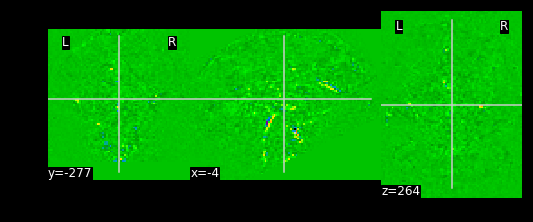

In [341]:
plotting.plot_epi(image.index_img(resid_img, 0)) 
plt.show()

In [343]:
resid_img.to_filename('residuals_sub2_tryout.nii.gz')

In [344]:
resid_img.shape

(79, 105, 82, 90)

In [345]:
cleaned_img = math_img('(resid_img + mean_img[...,np.newaxis]).astype(np.float32)', resid_img=resid_img, mean_img=(math_img('np.mean(aa,axis=-1)',aa=nib.load(funcdata[1]))))

In [346]:
cleaned_img.shape

(79, 105, 82, 90)

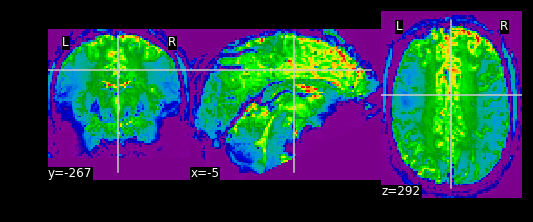

In [347]:
plotting.plot_epi(image.index_img(cleaned_img, 0)) 
plt.show()

In [349]:
cleaned_img.to_filename('clean_sub2_tryout.nii.gz')

In [350]:
(math_img('np.mean(aa,axis=-1)',aa=nib.load(funcdata[1]))).to_filename('mean_sub2_tryout.nii.gz')